# PART III
## Kernel perceptron

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(123)  # give a fixed seed for reproducability
from sklearn.model_selection import train_test_split

In [2]:
#loading data
zipcombo = np.loadtxt('zipcombo.dat')
zipcombo_qater = zipcombo[:len(zipcombo)//4]
training_data = np.loadtxt('dtrain123.dat')
test_data = np.loadtxt('dtest123.dat')

#some training data is continuous, need to make sure everything is either -1 or 1

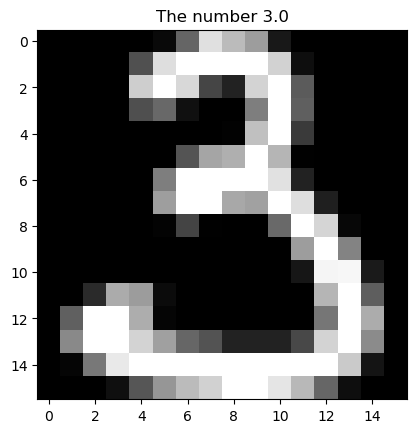

In [3]:
#plot first char
def plot_char(char):
    data = char[1:].reshape(16, 16)
    plt.imshow(data, cmap='gray')
    plt.title(f"The number {char[0]}")
    plt.show()
    
plot_char(training_data[0])

In [4]:
##helper functions(can be extracted into a separate class later)

#polynomial kernel

def polynomial_kernel(p, q, d):
    #from the previous coursework:adding a constant to the dot product of the two vectors
    return (1 + (p@q.T)) ** d

def polynomial_kernel_3D(p, q, d):
    #returns a 3D array of the polynomial kernel of the data, last dimension is the degree
    kernels = np.empty((len(d), len(q), len(p)))
    for i, degree in enumerate(d):
        kernels[i, :, :] = (1 + np.dot(p, q.T)) ** degree

    return kernels

#Gaussian kernel
def gaussian_kernel(p, q, sigma):
    #from previous coursework: exp(-||p-q||^2 / 2*sigma^2)
    return np.exp(-np.linalg.norm(p - q) ** 2 / (2 * sigma ** 2))

#convering the data to -1 and 1
def mysign(data):
    return np.where(data <= 0.0, -1.0, 1.0)

#splitting data and labels
def split_into_data_and_labels(data):
    y = data[:,0].astype(int)
    #convert to -1 and 1 here instead of in the loop
    x = data[:, 1:]
    return x, y

In [5]:
#v1
def train_perceptron(x, y, nb_epoches_max):
    w = np.zeros(x.shape[1])
    for e in range(nb_epoches_max):
        mistakes = 0
        nb_changes = 0
        for i in range(len(x)):
            if y[i] * np.dot(x[i], w) <= 0:
                w += y[i] * x[i]
                mistakes += 1
                nb_changes += 1
        if nb_changes == 0: break;
    return w    

In [6]:
#not online
def train_kernel_perceptron(X, y, num_epochs=10):
    num_samples = X.shape[0]
    alpha = np.zeros(num_samples)

    # Compute the kernel matrix
    K = polynomial_kernel(X, X)

    # Initialize mistake count and error rate lists
    mistakes = []
    error_rates = []

    for epoch in range(num_epochs):
        mistake_count = 0
        for i in range(num_samples):
            scores = sum(alpha[j] * y[j] * K[i, j] for j in range(num_samples))
            predicted_class = np.sign(scores)
            true_class = y[i]

            if predicted_class != true_class:
                alpha[i] += 1
                mistake_count += 1

        # Append mistake count and error rate for this epoch
        mistakes.append(mistake_count)
        error_rates.append(mistake_count / num_samples)

    return alpha, K, mistakes, error_rates

In [ ]:
#using summation??????
def train_kernel_perceptron_online_sum(X, y, alpha, K, i):
    num_samples = X.shape[0]
    scores = sum(alpha[j] * y[j] * K[i, j] for j in range(num_samples))
    predicted_class = np.sign(scores)
    true_class = y[i]

    mistake = 0
    if predicted_class != true_class:
        alpha[i] += 1
        mistake = 1

    return alpha, mistake

In [5]:
def train_kernel_perceptron_online(X, y, alpha, K, i, n_classes):
    num_samples = X.shape[0]
    scores = np.zeros(n_classes)

    for c in range(n_classes):
        y_c = np.where(y == c, 1, -1)  # Binary labels for class c vs. all other classes
        scores[c] = np.sum(alpha[c, :] * y_c * K[i, :])

    c_max = np.argmax(scores)
    predicted_class = c_max
    true_class = y[i]

    mistake = 0
    if predicted_class != true_class:
        alpha[true_class, i] += 1
        mistake = 1

    return alpha, mistake

In [6]:
def predict_kernel_perceptron(X_test, y_test, alpha, K):
    # Calculate the scores for all test samples and classes at once
    scores = np.dot(alpha, K.T)

    # Predict the class with the highest score for each test sample
    y_pred = np.argmax(scores, axis=0)

    test_error = np.mean(y_test != y_pred)
    return test_error

## Q1

In [21]:
N_RUNS = 1
d = np.arange(1, 7, dtype=int)  # k = 1...7
#substitute for the real data with 10
x_data, y_labels = split_into_data_and_labels(zipcombo)
test_error = np.zeros((N_RUNS, len(d)))
train_error = np.zeros((N_RUNS, len(d)))
#can be extraced from data
n_classes = 10
nb_epoches_max = 30

def run_experiment(x_data, y_labels, d, nb_epoches_max):
    for i_run in range(N_RUNS):
        # Use i_run as random state so each run is reproducable
        X_train, X_test, Y_train, Y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
        mistakes = np.zeros((len(X_train), len(d)))
        w = np.zeros(( len(d), len(X_train), len(X_train)))     
        K_matrix = polynomial_kernel_3D(X_train, X_train, d)
        assert K_matrix.shape == (len(d), len(X_train), len(X_train))
        for j in range(len(d)):
            for e in range(nb_epoches_max):
                nb_changes = 0
                for i in range(len(X_train)):
                    prediction = mysign(np.dot(w[j, :, :], K_matrix[j, i, :]))
                    if prediction*Y_train[i] <= 0:
                        w[Y_train[i], i, j] += 1
                        nb_changes += 1
                        mistakes[i, j] += 1
                if nb_changes == 0: break;
        # Compute the kernel matrix
        K_test = polynomial_kernel(X_test, X_train)
        K_train = polynomial_kernel(X_train, X_train)
        for j in range(len(d)):
            # Compute the scores
            scores = sum(w[j, i, :] * K_test[i, :] for i in range(len(X_test)))
            # Compute the predicted classes
            predicted_classes = np.sign(scores)
            # Compute the error rate
            test_error[i_run, j] = np.mean(predicted_classes != Y_test)
            # Compute the scores
            scores = sum(w[j, i, :] * K_train[i, :] for i in range(len(X_train)))
            # Compute the predicted classes
            predicted_classes = np.sign(scores)
            # Compute the error rate
            train_error[i_run, j] = np.mean(predicted_classes != Y_train)
    return test_error, train_error, mistakes


for i_run in range(N_RUNS):
    # Use i_run as random state so each run is reproducable
    X_train, X_test, Y_train, Y_test = train_test_split(
        x_3_data, y_3_labels, test_size=0.2, random_state=i_run
    )
    # mistakes = np.zeros((len(X_train), len(d)))
    # w = np.zeros(( len(d), len(X_train), len(X_train)))     
    # K_matrix = polynomial_kernel_3D(X_train, X_train, d)
    # assert K_matrix.shape == (len(d), len(X_train), len(X_train))
    
    print(X_train.shape[0])
    # mistakes = np.zeros(( len(d)))
    
    for j in d:
        #all of these can be take out of the loop and add dimension of the polynomial
        K = polynomial_kernel(X_train, X_train, j)
        w = np.zeros((n_classes, X_train.shape[0]))
        print("K shape ", K.shape)
        for e in range(nb_epoches_max):
            # nb_changes = 0
            # for i in range(len(X_train)):
                #dot product outputs accumulative scores for each class
                #argmax returns the index of the class with the highest score
                # prediction = np.argmax((np.dot(w, K)))
                # if prediction+1 != Y_train[i]:
                #     w[Y_train[i]-1, :] += 1
                #     w[prediction, :] -= 1
                #     nb_changes += 1
                #     mistakes[j] += 1
            #if nb_changes == 0: break;
            for i in range(len(X_train)):
                alpha, mistake = train_kernel_perceptron_online(X_train, Y_train, w, K, i)
                w = alpha
    

    
        
        
        
    


KeyboardInterrupt: 

In [7]:
N_RUNS = 1
d = np.arange(1, 8, dtype=int)  # k = 1...7
#substitute for the real data with 10
x_data, y_labels = split_into_data_and_labels(zipcombo_qater)
#can be extraced from data
n_classes = len(np.unique(y_labels))
NB_EPOCHS_MAX = 10

def run_experiment(x_data, y_labels, N_RUNS, NB_EPOCHS_MAX, d, n_classes):
    train_errors = np.zeros((N_RUNS, len(d)))
    test_errors = np.zeros((N_RUNS, len(d)))

    for i_run in range(N_RUNS):
        X_train, X_test, y_train, y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
        n_training_samples = X_train.shape[0]

        for j_ind, j in enumerate(d):
            K = polynomial_kernel(X_train, X_train, j)
            alpha = np.zeros((n_classes, n_training_samples))

            for epoch in range(NB_EPOCHS_MAX):
                for i in range(len(X_train)):
                    alpha, mistake = train_kernel_perceptron_online(X_train, y_train, alpha, K, i, n_classes)
                    if mistake:
                        train_errors[i_run, j_ind] += 1
            print(f"Run {i_run}, degree {j}, train error {train_errors[i_run, j_ind]}, number of samples {n_training_samples}")
                        
            train_errors = train_errors / (NB_EPOCHS_MAX * n_training_samples)
            print(f"Run {i_run}, degree {j}, train error {train_errors[i_run, j_ind]}")
            
            # calculating prediction of the test data
            K_test = polynomial_kernel(X_test, X_train, j)
            test_errors[i_run, j_ind] = predict_kernel_perceptron(X_test, y_test, alpha, K_test)
            print(f"Run {i_run}, degree {j}, test error {test_errors[i_run, j_ind]}")

    mean_train_errors = np.mean(train_errors, axis=0)
    print(f"Mean train errors {mean_train_errors}")
    mean_test_errors = np.mean(test_errors, axis=0)
    print(f"Mean test errors {mean_test_errors}")
    mean_std_train_errors = np.std(train_errors, axis=0)
    print(f"Mean std train errors {mean_std_train_errors}")
    mean_std_test_errors = np.std(test_errors, axis=0)
    print(f"Mean std test errors {mean_std_test_errors}")
    
    return mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors

mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors = run_experiment(x_data, y_labels, N_RUNS, NB_EPOCHS_MAX, d, n_classes)

Run 0, degree 1, train error 1516.0, number of samples 1859
Run 0, degree 1, train error 0.08154922001075847
Run 0, degree 1, test error 0.1032258064516129
Run 0, degree 2, train error 615.0, number of samples 1859
Run 0, degree 2, train error 0.03308230231307154
Run 0, degree 2, test error 0.08387096774193549
Run 0, degree 3, train error 374.0, number of samples 1859
Run 0, degree 3, train error 0.020118343195266272
Run 0, degree 3, test error 0.060215053763440864
Run 0, degree 4, train error 312.0, number of samples 1859
Run 0, degree 4, train error 0.016783216783216783
Run 0, degree 4, test error 0.06451612903225806
Run 0, degree 5, train error 250.0, number of samples 1859
Run 0, degree 5, train error 0.013448090371167294
Run 0, degree 5, test error 0.06881720430107527
Run 0, degree 6, train error 242.0, number of samples 1859
Run 0, degree 6, train error 0.01301775147928994
Run 0, degree 6, test error 0.06666666666666667
Run 0, degree 7, train error 234.0, number of samples 1859
R

In [ ]:
import numpy as np

# Function to compute the polynomial kernel of degree 3
def compute_kernel(a, b):
    return (np.dot(a, b))**3

# Function to compute the sign of a number
def compute_sign(x):
    return -1.0 if x <= 0.0 else 1.0

# Function to initialize the classifier weights
def initialize_weights(data):
    return np.zeros((3, len(data)))

# Function to compute the prediction for a given pattern
def compute_prediction(data, pattern, classifier):
    return sum(classifier[i] * compute_kernel(pattern, data[i][1:]) for i in range(len(classifier)))

# Function to train the classifiers
def train_classifiers(data):
    global classifier_weights
    classifier_weights = initialize_weights(data)
    num_mistakes = 0

    for i in range(len(data)):
        true_class = data[i][0]

        # Compute the predictions of the 3 classifiers
        predictions = [compute_prediction(data, data[i][1:], classifier_weights[j]) for j in range(3)]
        
        max_prediction = float("-inf")
        for j in range(3):
            expected_output = 1.0 if true_class == (j + 1) else -1.0
            
            # Update the classifier weights if the prediction is incorrect
            if expected_output * predictions[j] <= 0:
                classifier_weights[j, i] -= compute_sign(predictions[j])
            if predictions[j] > max_prediction:
                max_prediction = predictions[j]
                predicted_class = j + 1
                
        # Increment the mistake counter if the predicted class is not the true class
        if predicted_class != true_class:
            num_mistakes += 1

    return num_mistakes

# Train the model and get the number of mistakes
mistakes = train_classifiers(training_data)
print("Number of mistakes:", mistakes)

# Access the global variable GLBcls after training
print("GLBcls shape:", classifier_weights.shape)

In [ ]:
# Create a summary table
columns = ['method', 'MSE train mean', 'MSE train std', 'MSE test mean', 'MSE test std']

df_naive_regression = pd.DataFrame(
    [[
        'Naive Regression', train_error.mean(), train_error.std(), test_error.mean(), test_error.std()
    ]],
    columns=columns
)
df_naive_regression.set_index('method', inplace=True)
df_naive_regression.to_latex('naive_regression.tex', float_format="{:.2f}".format)

# Take an average over all the runs
df_single_attr_regression = pd.concat(
    (
        pd.DataFrame(train_error.mean(axis=0), columns=[columns[1]]),
        pd.DataFrame(train_error.std(axis=0), columns=[columns[2]]),
        pd.DataFrame(test_error.mean(axis=0), columns=[columns[3]]),
        pd.DataFrame(test_error.std(axis=0), columns=[columns[4]])),
    axis=1
)
# Create the labels for each attribute
df_single_attr_regression['method'] = [f'Linear Regression (attribute {i})' for i in df_single_attr_regression.index]
df_single_attr_regression.set_index('method', inplace=True)
df_single_attr_regression.to_latex('single_attr_regression.tex', float_format="{:.2f}".format)

df_all_attrs_regression = pd.DataFrame(
    [[
        'Linear Regression (all attributes)', mse_all_train.mean(), mse_all_train.std(), mse_all_test.mean(),
        mse_all_test.std()
    ]],
    columns=columns
)
df_all_attrs_regression.set_index('method', inplace=True)
df_all_attrs_regression.to_latex('all_attrs_regression.tex', float_format="{:.2f}".format)

# Combine into a summary table for all the linear regression methods
df_linear_summary = pd.concat((df_naive_regression, df_single_attr_regression, df_all_attrs_regression), axis=0)
df_linear_summary